<a href="https://colab.research.google.com/github/Yanlecun/intro_ml_notebooks/blob/main/%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%892%3AEDA_To_Prediction(Dietanic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sometimes life has a cruel sense of humor, giving you the thing you always wanted at the worst time possible

sources by : https://www.kaggle.com/ash316/eda-to-prediction-dietanic

In [14]:
# 캐글 설치하기
#!pip install kaggle
#from google.colab import files
#files.upload()

In [15]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [16]:
# ! kaggle competitions download -c titanic

In [17]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))


# (0) 개요
<p>
2224명 중 1502의 사상자를 내어 'Dietanic'이라고 지었다.
특징을 체크, 새로운 특징을 추가하며 머신러닝의 개념을 곁들이는 과정으로 <br> 예측 모델링 문제의 작업흐름이 어떤지에 대한 관점을 줄 것이다.
</p>

1. EDA
    1. 특징에 대한 분석
    2. 다양한 특징을 고려한 특징 사이의 관계성이나 방향성 탐색
2. Feature Engineering and Data Cleaning
    1. 특징 추가
    2. 관계 의존도 높은 특징 제거
    3. 특징들을 모델링을 위해 적절한 형태로 변형
3. Predictive Modeling
    1. 기본 알고리즘
    2. Cross Validation
    3. 앙상블
    4. 중요한 특징 추출

# (1) EDA

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [19]:
data = pd.read_csv('train.csv')

In [20]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 데이터 결측치 확인

In [21]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Embarked 값에 결측치가 있음

## 얼마나 많이 살아남았을까?

Text(0.5, 1.0, 'Survived')

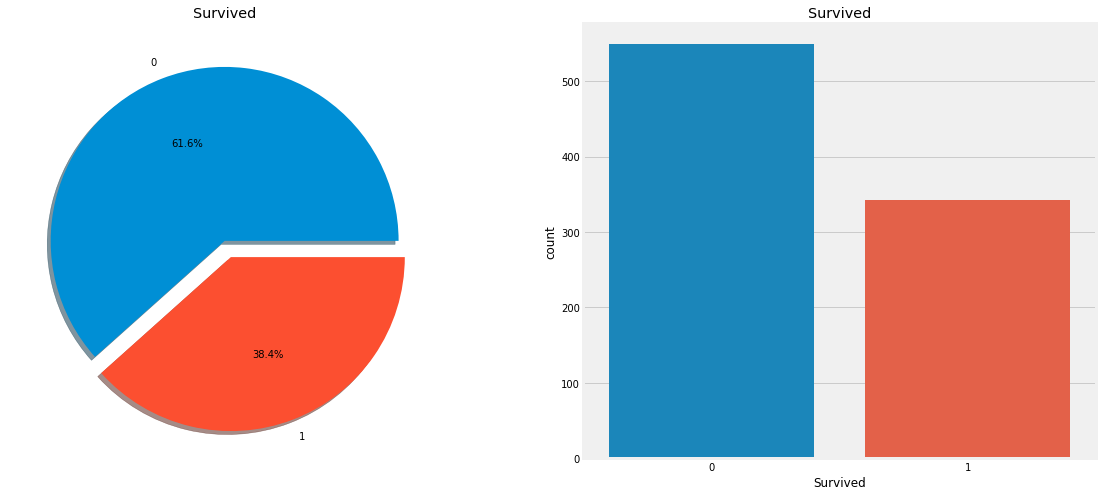

In [22]:
f, ax = plt.subplots(1,2,figsize=(18,8))

# Pie Chart
data['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax= ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')


train dataset에 의하면 38.4%가 생존했다는 것을 알 수 있었는데, 더 나은 관점을 위해 각 특징과 생존비율에 대한 관계성을 살펴보자.

## Feature 살펴보기

### 1. 범주형 특징
- sex, embarked같이 상대적 순서는 없어 순서 정렬할 수 없는 특징

### 2. Ordinal 특징
- Height(Tall, Midium, short)값에 상대적 순서가 있어 순서정렬이 가능한 범주형 특징


### 3. Continous 특징
- Age처럼 이진값이나 최대/최소값을 가진 특징 

## Feature 분석

### (1) 범주형 특징(sex)    

In [23]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

Text(0.5, 1.0, 'Sex: Survived vs Sex')

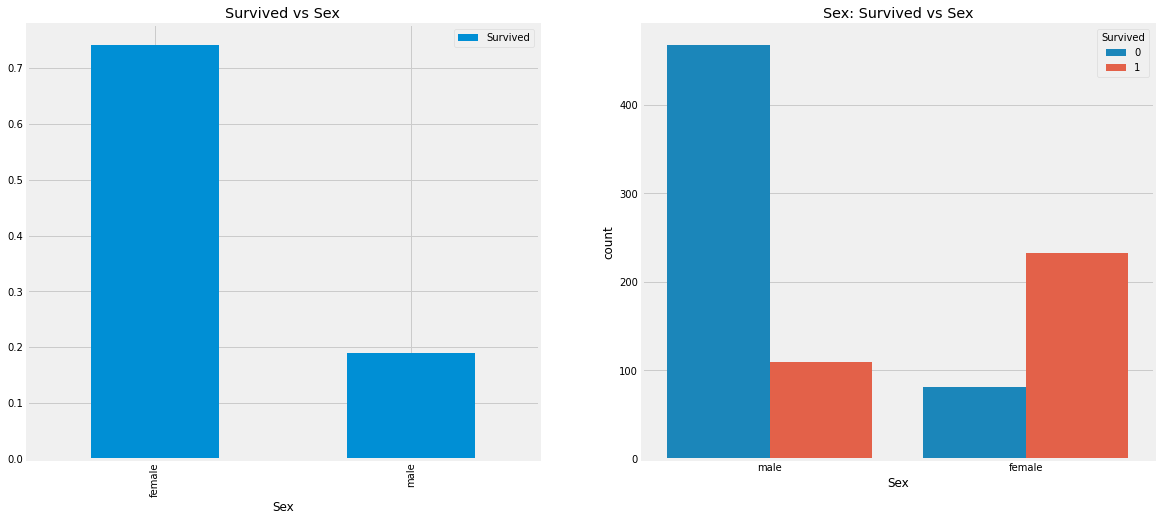

In [24]:
f, ax = plt.subplots(1,2, figsize=(18,8))

data[['Sex', 'Survived']].groupby('Sex').mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex', hue='Survived', data=data,ax=ax[1])
ax[1].set_title('Sex: Survived vs Sex')

### (2) Ordinal 특징 (Pclass)

In [25]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Text(0.5, 1.0, 'Pclass: Survived vs Dead')

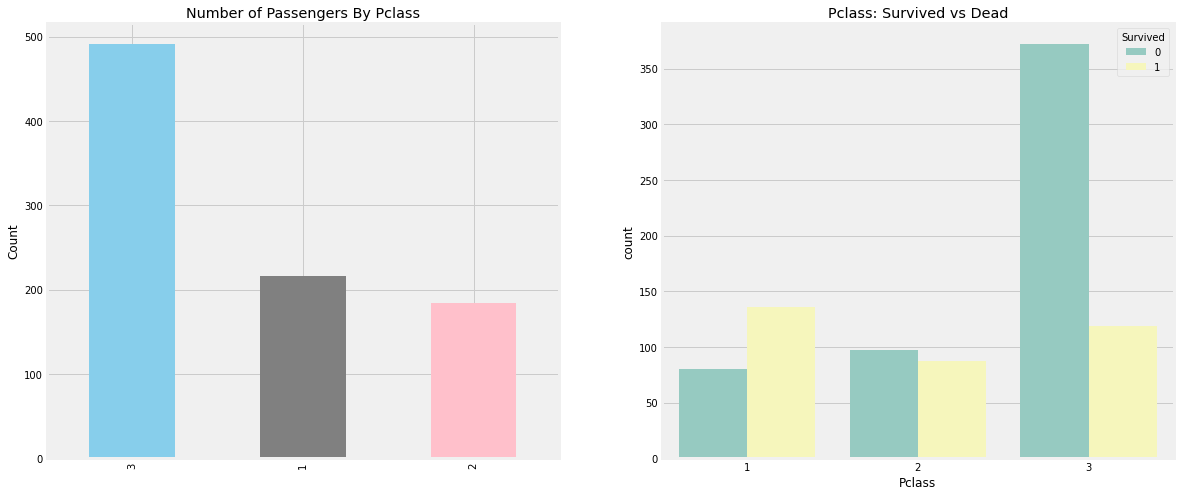

In [26]:
f, ax = plt.subplots(1,2, figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['skyblue','gray','pink'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot('Pclass', hue='Survived', palette='Set3', data=data, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')


퍼스트 클래스가 가장 높은 생존확률을 나타내고 있다. <br>Sex와 Pclass 간의 관계를 살펴보자

In [27]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient('summer_r')

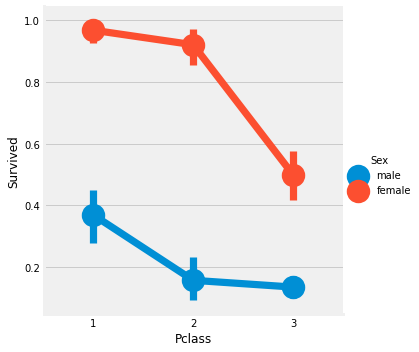

In [28]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=data)

**factorplot는 범주형의 데이터를 쉽게 분리한다는 장점이 있다.**
<br> <p>Pclass 1인 여성이 94%의 생존률을 보여주고 있으며, Pclass 관계없이 여성의 생존률이 높은 것을 보았을 때 여성 먼저 구조된 것을 추론할 수 있다.</p>

### (3) Continous 특징 (Age)

In [29]:
print('Oldest Passenger was of:', data['Age'].max(), 'Years')
print('Youngest Passenger was of:', data['Age'].min(), 'Years')
print('Average age ont the ship:', data['Age'].mean(), 'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average age ont the ship: 29.69911764705882 Years


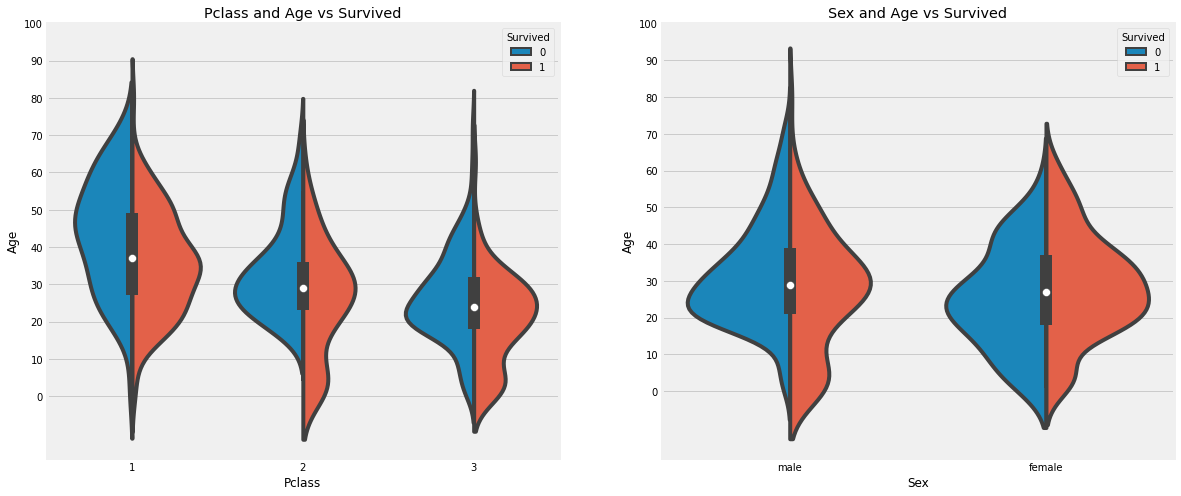

In [30]:
f, ax = plt.subplots(1,2, figsize=(18,8))

sns.violinplot('Pclass', 'Age', hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot('Sex', 'Age', hue='Survived', data=data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

1. 10살 이하의 경우, Pclass 특징의 영향에 관계없다.
2. 20-50살 사이의 대한 생존은 Pclass의 영향을 받으며, 역시 여자 쪽에서 좀 더 높은 생존률을 보이고 있다.
3. 남자의 경우, 나이와 생존률이 반비례 관계임을 확인할 수 있다.

#### 결측치 채우기

Age의 결측치는 평균치로 채우는데, 4살 배기한테 29살을 넣을 수는 없다.. **Name 특징**을 이용해보자
<br> Mr, Mrs 처럼 각각의 Name 특징 그룹으로 나눠 그 그룹의 나이의 평균값으로 결측치를 채우면 더 나을 것이다.

In [31]:
data['Initial'] = 0
for i in data :
    data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.') # Salutations 추출

In [32]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient('summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


misspelled 이니셜들을 한 단위로 모으자

In [33]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [34]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [35]:
data.loc[(data.Age.isnull())&(data.Initial=='Mr'), 'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'), 'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'), 'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'), 'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'), 'Age']=46

In [36]:
data.Age.isnull().any()

False

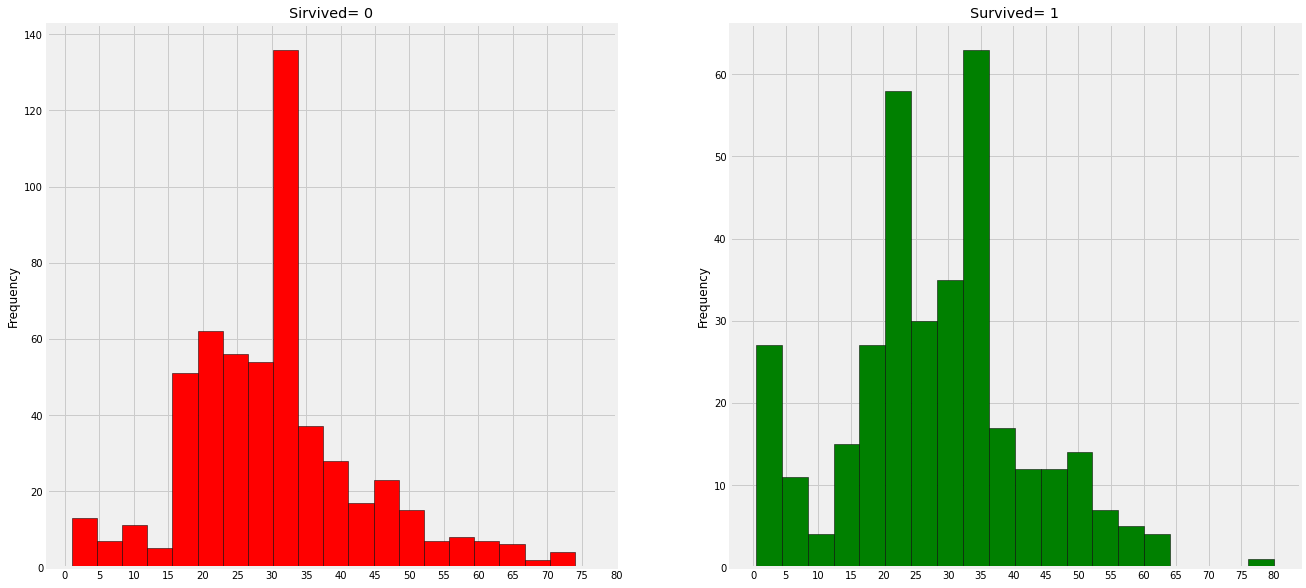

In [37]:
f, ax = plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('Sirvived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

data[data['Survived']==1].Age.plot.hist(ax=ax[1], bins=20, edgecolor='black', color='green')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)

plt.show()        

1. 5살 미만의 애기들 또한 높은 구조 우선순위였음
2. 80 years was saved
3. 30-40대가 제일 많이 사망하였음

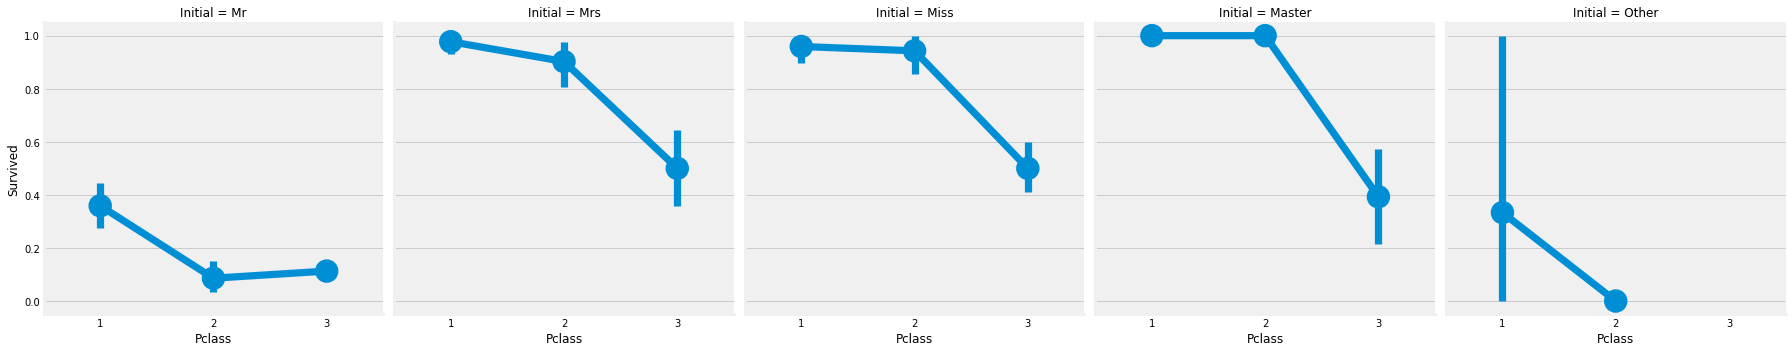

In [38]:
sns.factorplot('Pclass', 'Survived', col='Initial', data=data)
plt.show()

class상관없이 여자와 아이가 우선으로 구조되었음을 알 수 있다.

### (4) 범주형 특징 (Embarked)

In [39]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient('summer_r')

**Embarkation에 따른 생존 기회**

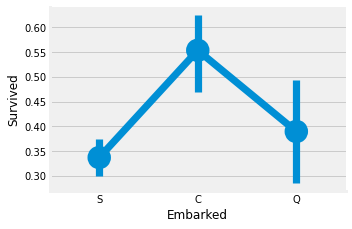

In [40]:
sns.factorplot('Embarked', 'Survived', data=data)
fig = plt.gcf()
fig.set_size_inches(5,3)
plt.show()

C는 55%가까이인 반면, S가 가장 낮은 생존확률을 보여주었다.

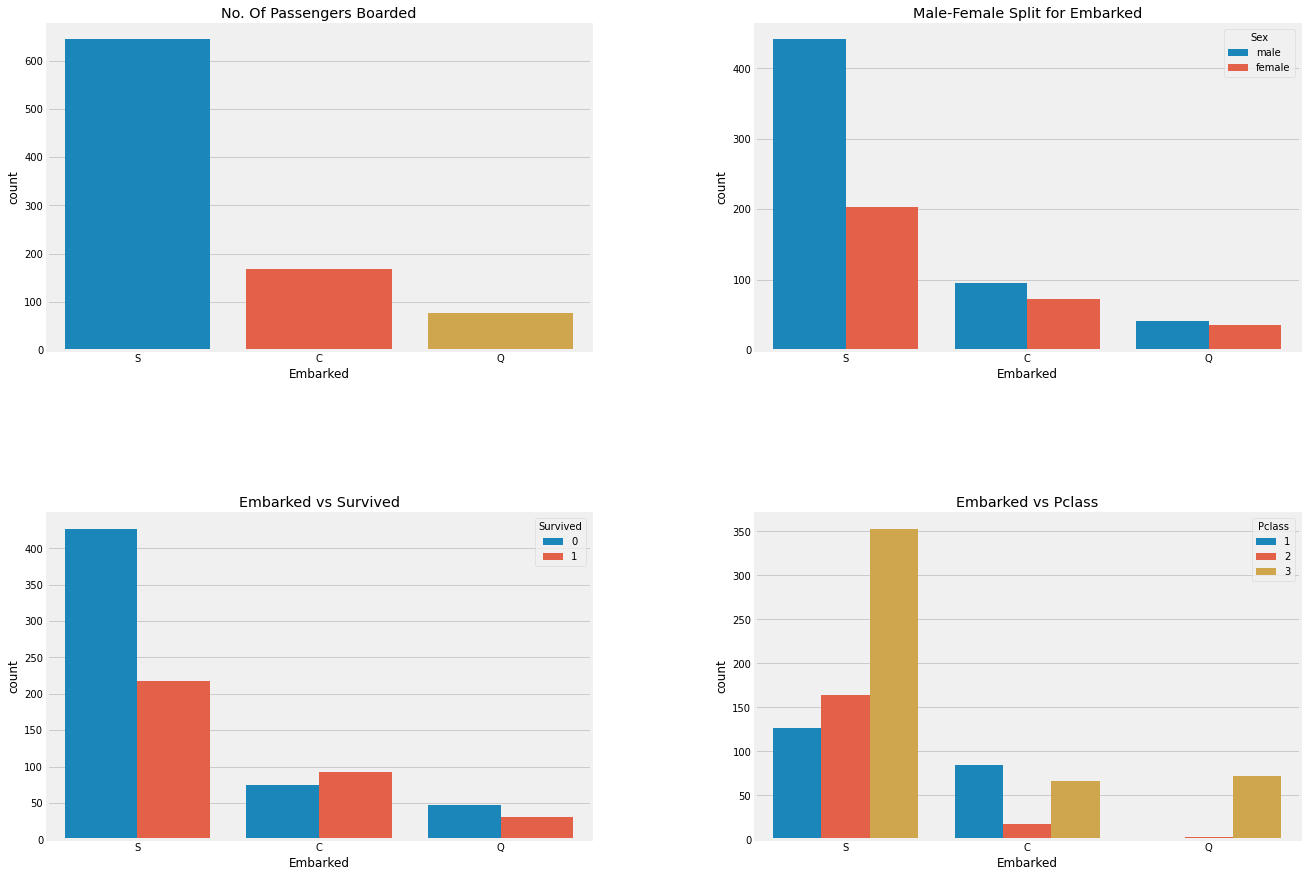

In [41]:
f,ax = plt.subplots(2,2, figsize=(20,15))
sns.countplot('Embarked', data=data, ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex', data=data, ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived', data=data, ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass', data=data, ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

1. S에서 가장 많이 탑승했고 대부분은 Pclass 3
2. C에서 탑승한 사람들이 생존을 많이 했는데, 생존자 중 대부분이 Pclass1,2 일 것으로 추정된다.
3. S가 부유한 사람 대다수가 탑승 한 것으로 보이나 Pclass3 고객이 많이 살아남지 못해 생존확률이 낮아보인다.
4. Q는 95%가 Pclass3 고객이다.

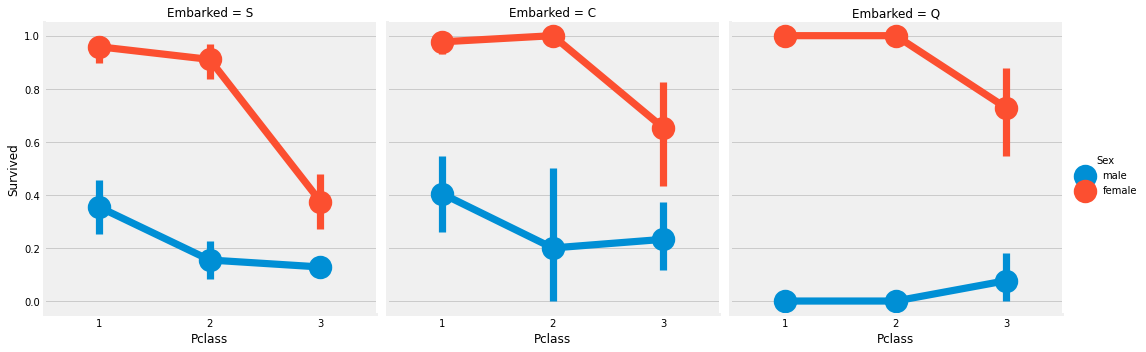

In [42]:
sns.factorplot('Pclass', 'Survived', hue='Sex', col='Embarked', data=data)
plt.show()

1. Pclass 관계없이 Pclass 1,2인 여자가 구조 우선순위가 높았다는 것을 알 수 있었다.
2. port S의 경우 남녀 모두 Pclass3 생존률이 낮다.
3. port Q에서 탑승한 Pclass3 남자가 가장 불운했다.

#### 결측치 채우기 <br>
S에서 가장 많은 탑승객들이 탑승했기에 NaN을 S로 채우자.

In [43]:
data['Embarked'].fillna('S', inplace=True)

In [44]:
data.Embarked.isnull().any()

False

### (5) 이진 특징 (SibSp)
혼자냐 가족과 함께 탔느냐를 나타내는 특징. Sibling = bro,sis,stepbro,stepsis / Spouse = husband,wife

In [45]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [46]:
pd.crosstab([data.SibSp], data.Survived).style.background_gradient('Pastel2')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


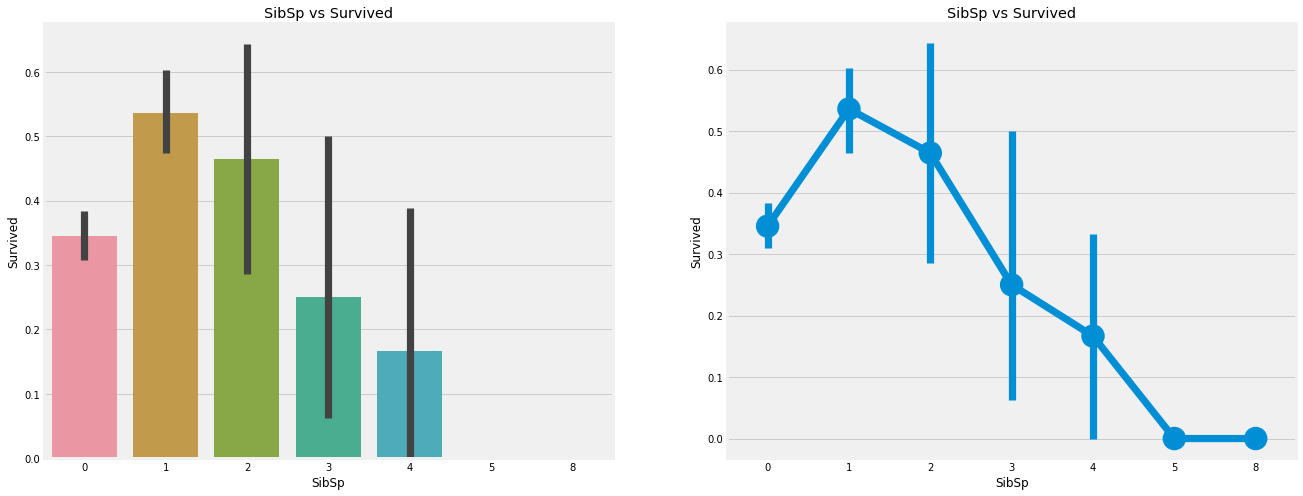

In [47]:
f, ax = plt.subplots(1,2, figsize=(20,8))

sns.barplot('SibSp', 'Survived', data=data, ax=ax[0])
ax[0].set_title('SibSp vs Survived')

sns.pointplot('SibSp', 'Survived', data=data, ax=ax[1])
ax[1].set_title('SibSp vs Survived')

plt.show()

In [48]:
pd.crosstab(data.SibSp, data.Pclass).style.background_gradient('Pastel2')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


가족이 없는 탑승객은 34.5%의 생존률을 보였다. 가족이 있을 경우 생존확률이 급격히 떨어졌고 이는 나보다 가족이 우선이라는 의식 때문에 떨어진 것으로 보인다. 다만 5명 이후에는 생존률이 0%인데 Pclass때문일까 ? <br>
crosstab 그래프를 참고하였을 때 **Pclass를 이유로 5명 이후에는 생존률이 낮았다고 볼 수 있다.**

### (6) Discrete 특징 (Parch (부모, 자녀))

In [49]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient('Pastel1_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


더많은 가족들이 Pclass3에 소속되어 있다는 것을 알 수 있었다.

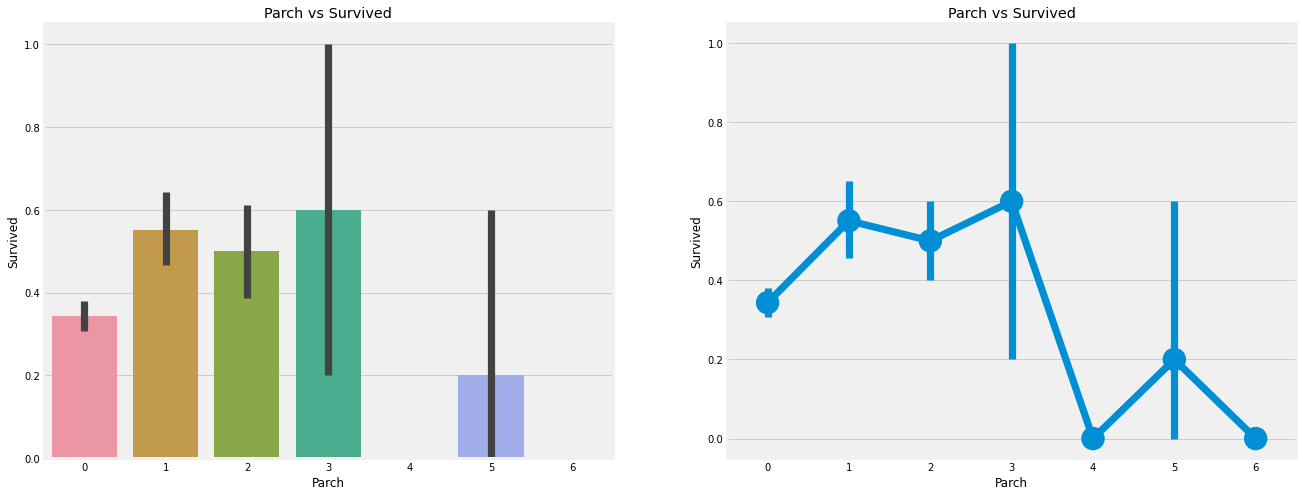

In [50]:
f, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot('Parch', 'Survived', data=data, ax=ax[0])
ax[0].set_title('Parch vs Survived')

sns.pointplot('Parch', 'Survived', data=data, ax=ax[1])
ax[1].set_title('Parch vs Survived')

plt.show()

2개의 결과가 비슷한데, 가족이 1-3명 있을 경우 생존률이 높아지지만, 일정 수 이상의 경우 급격히 떨어졌으며, 혼자일 경우에도 낮은 경향을 보였다.

### (7) Continous 특징 (Fare)

In [51]:
print('Highest Fare was:', data['Fare'].max())
print('Lowest Fare was:', data['Fare'].min())
print('Average Fare was:', data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


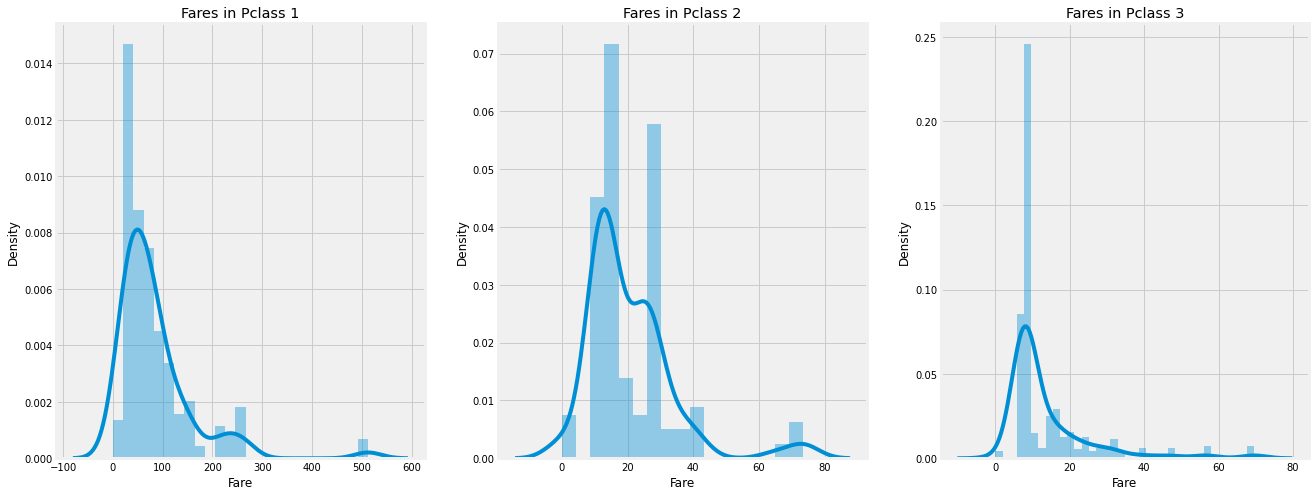

In [52]:
f, ax = plt.subplots(1,3, figsize=(20,8))

sns.distplot(data[data['Pclass']==1].Fare, ax=ax[0])
ax[0].set_title('Fares in Pclass 1')

sns.distplot(data[data['Pclass']==2].Fare, ax=ax[1])
ax[1].set_title('Fares in Pclass 2')

sns.distplot(data[data['Pclass']==3].Fare, ax=ax[2])
ax[2].set_title('Fares in Pclass 3')

plt.show()

binning을 이용하여 discrete values로 변환할 필요가 있다.